# Train EfficientNet on Fruits 360

We want to use the latest version of `torchvision`, Kaggle's current version of torchvision doesn't include EfficientNet, it was added in a later release

In [1]:
# !pip install -U torchvision
# !pip install timm

## Imports

Import all necesssary libraries for this project

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

In [4]:
torchvision.__version__, 
torch.__version__ 
# ('0.11.2+cu102', '1.10.1+cu102') or higher

'1.10.1+cu113'

In [5]:
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
from tqdm import tqdm
import time
import copy

## Dataset

In [7]:
# dataset_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/"
dataset_path = "../input/fruits-360-original-size/"
# dataset_path = "../../Datasets/Oxford-102-Floweres-350mb/dataset/"

In [8]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_set = datasets.ImageFolder(os.path.join(data_dir, "Training/"), transform=transform)
        # train_set = datasets.ImageFolder(os.path.join(data_dir), transform=transform)
        
        
        print(f"Found {len(train_set)} images for training with {len(train_set.classes)} classes")
        train_data_len = int(len(train_set)*0.78)
        valid_data_len = int((len(train_set) - train_data_len))
        
        train_data, val_data = random_split(train_set, [train_data_len, valid_data_len])
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        
        return train_loader, val_loader, len(train_data), len(val_data)
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Test/"), transform=transform)
        print(f"Found {len(test_data)} images for testing with {len(test_data.classes)} classes")
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return test_loader, len(test_data)

In [9]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [10]:
classes = get_classes(os.path.join(dataset_path, "Training/"))
len(classes)

24

In [11]:
(train_loader, val_loader, train_data_len, valid_data_len) = get_data_loaders(dataset_path, 256, train=True)
(test_loader, test_data_len) = get_data_loaders(dataset_path, 64, train=False)

Found 6231 images for training with 24 classes
Found 3110 images for testing with 24 classes


In [12]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}

dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [13]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

19
6
49


In [14]:
print(train_data_len, test_data_len, valid_data_len)

4860 3110 1371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

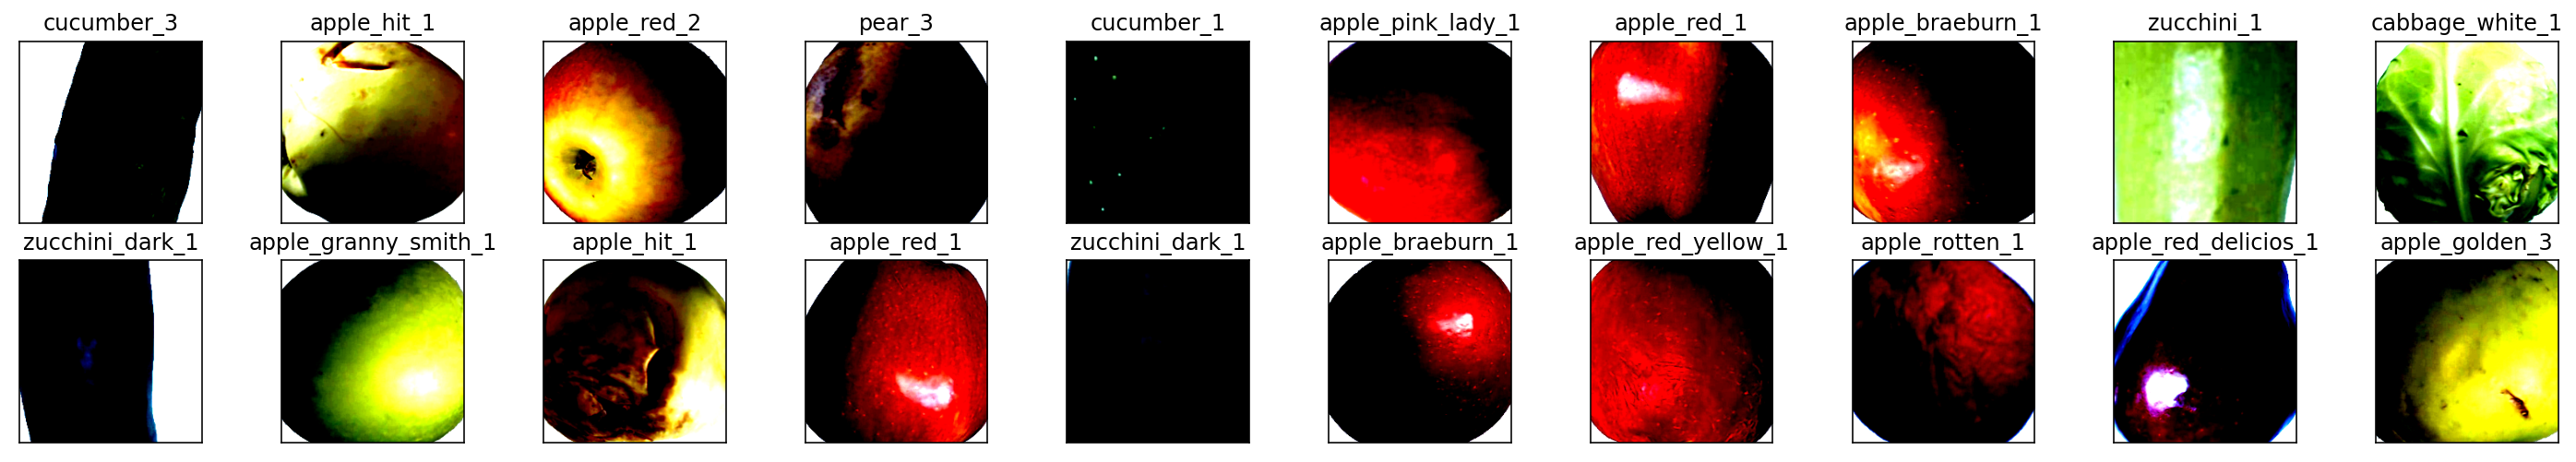

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Model

Load `efficientnet_b0` from torchvision Models

In [16]:
import timm
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
device

'cpu'

In [17]:
torch.backends.cudnn.benchmark = True # This will speed up training

model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=24, bias=True)
)


In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [19]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [20]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

## Training

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    print('outputs on which to apply torch.max ', outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


  5%|▌         | 1/19 [00:13<04:00, 13.35s/it]

outputs on which to apply torch.max  tensor([[ 0.0678,  0.0108, -0.0522,  ...,  0.0103, -0.0139, -0.0222],
        [ 0.0306, -0.0731, -0.1118,  ...,  0.1506, -0.0332,  0.0326],
        [-0.0730,  0.0098, -0.0033,  ...,  0.1802, -0.0443, -0.0929],
        ...,
        [-0.0583,  0.1180,  0.0499,  ...,  0.0128,  0.0842,  0.0448],
        [ 0.0072, -0.0779,  0.0520,  ...,  0.0437, -0.0156,  0.1004],
        [-0.2873,  0.1128,  0.1517,  ..., -0.0819, -0.1922,  0.0590]],
       grad_fn=<AddmmBackward0>)


 11%|█         | 2/19 [00:22<03:03, 10.82s/it]

outputs on which to apply torch.max  tensor([[-0.0532,  0.1786,  0.0909,  ..., -0.4203, -0.5954, -0.2861],
        [ 0.1657,  0.0371, -0.1089,  ..., -0.2446, -0.2125, -0.0746],
        [-0.0196,  0.0165, -0.1508,  ..., -0.2517, -0.1154, -0.0766],
        ...,
        [ 0.0156,  0.5491,  0.0351,  ..., -0.4226, -0.5763, -0.3002],
        [ 0.1656, -0.0366, -0.1197,  ..., -0.1814, -0.1972, -0.1523],
        [-0.2328,  0.2808,  0.0298,  ..., -0.3891, -0.4876, -0.1592]],
       grad_fn=<AddmmBackward0>)


 16%|█▌        | 3/19 [00:31<02:38,  9.88s/it]

outputs on which to apply torch.max  tensor([[-0.0218,  1.1284,  0.5946,  ..., -0.9449, -1.1801, -0.8694],
        [-0.0880,  0.6735,  0.1545,  ..., -0.3242, -0.5904, -0.1930],
        [-0.2923,  0.5286,  0.8449,  ..., -0.4109, -0.7579, -0.3821],
        ...,
        [-0.3052,  0.0552,  0.1650,  ..., -0.3700, -0.4240, -0.2917],
        [-0.0629, -0.2196, -0.1477,  ...,  0.2492,  0.3251,  0.5787],
        [-0.1319,  0.1487,  0.1187,  ..., -0.2147, -0.4095, -0.1748]],
       grad_fn=<AddmmBackward0>)


 21%|██        | 4/19 [00:40<02:24,  9.60s/it]

outputs on which to apply torch.max  tensor([[-0.1794,  0.5679,  0.5956,  ..., -0.4178, -0.6826, -0.5828],
        [ 0.4106,  0.2598,  0.9732,  ..., -0.8503, -1.1729, -1.0810],
        [-0.1710,  1.7001,  0.7391,  ..., -0.5816, -0.8959, -0.7550],
        ...,
        [-0.2823,  1.8750,  0.3439,  ..., -0.3073, -0.6533, -0.3667],
        [-0.0997,  0.2670,  0.3346,  ..., -0.4761, -0.7753, -0.5126],
        [-0.0236,  0.6615,  1.0347,  ..., -0.6448, -1.5435, -0.9480]],
       grad_fn=<AddmmBackward0>)


 26%|██▋       | 5/19 [00:50<02:14,  9.63s/it]

outputs on which to apply torch.max  tensor([[ 1.4175e-01,  1.3654e+00,  2.6441e+00,  ..., -6.7767e-01,
         -1.8660e+00, -1.5823e+00],
        [ 7.6163e-01, -8.4126e-02,  2.4787e-03,  ..., -7.5675e-01,
         -1.2348e+00, -1.1589e+00],
        [-2.3462e-01,  2.8215e-01,  8.5702e-01,  ..., -2.0168e-01,
         -8.3298e-01, -4.6703e-01],
        ...,
        [ 7.0527e-01, -3.9317e-02,  3.5622e-01,  ..., -4.3845e-01,
         -1.1404e+00, -6.1054e-01],
        [ 3.6385e-01,  1.3174e-01,  6.6629e-01,  ..., -2.2436e-01,
         -8.9539e-01, -8.1985e-01],
        [ 1.0418e-01, -2.4736e-01, -1.5574e-01,  ..., -3.9326e-02,
          5.1347e-01,  7.5581e-01]], grad_fn=<AddmmBackward0>)


 32%|███▏      | 6/19 [00:59<02:05,  9.67s/it]

outputs on which to apply torch.max  tensor([[-0.3327,  3.3325,  1.8265,  ..., -0.9375, -2.1761, -1.9923],
        [-0.2520,  0.2201,  0.7020,  ...,  0.1063, -1.3632, -0.9715],
        [-0.1950,  1.3395,  0.8964,  ..., -0.3789, -1.0528, -0.8195],
        ...,
        [-0.3282, -0.0247, -0.3448,  ..., -0.0419,  0.5019,  0.7788],
        [-0.0099,  0.6075,  1.9352,  ..., -0.1132, -1.3107, -0.8023],
        [-1.1702, -0.0645,  0.7879,  ..., -0.4269, -2.0660, -1.5958]],
       grad_fn=<AddmmBackward0>)


 37%|███▋      | 7/19 [01:09<01:56,  9.74s/it]

outputs on which to apply torch.max  tensor([[ 1.1527, -0.9635, -0.9363,  ...,  0.0861, -1.5586, -1.8429],
        [ 0.8645, -0.2812,  0.5365,  ..., -0.4045, -0.7544, -0.9181],
        [-0.4157,  1.4972,  1.9409,  ..., -0.5005, -2.0205, -1.3161],
        ...,
        [ 0.2179, -0.4831, -0.1270,  ..., -0.1566,  0.3413,  0.8929],
        [ 0.4373, -0.0926,  3.3962,  ...,  0.0920, -1.8911, -1.9555],
        [-0.1760,  0.1023,  1.4280,  ...,  0.5125, -2.4399, -2.1502]],
       grad_fn=<AddmmBackward0>)


 42%|████▏     | 8/19 [01:20<01:50, 10.06s/it]

outputs on which to apply torch.max  tensor([[-1.1488e-01,  6.4042e-01,  1.3863e+00,  ...,  2.2959e-01,
         -2.0694e+00, -1.8208e+00],
        [ 1.0302e+00, -5.9432e-02,  1.4652e+00,  ...,  2.6734e-01,
         -1.3448e+00, -1.7948e+00],
        [ 1.6558e+00, -9.4693e-01, -6.2901e-01,  ...,  2.1747e+00,
         -8.5916e-01, -1.4406e+00],
        ...,
        [ 2.1386e+00, -6.0865e-01,  8.7372e-02,  ...,  5.4467e-01,
         -3.1826e+00, -3.6908e+00],
        [ 6.0102e-01, -7.5386e-01,  5.8272e-01,  ..., -1.3119e-03,
         -1.4176e+00, -1.4840e+00],
        [-1.6349e-01,  4.3329e-01,  1.4995e-01,  ..., -4.8123e-01,
         -2.1179e+00, -1.7247e+00]], grad_fn=<AddmmBackward0>)


 47%|████▋     | 9/19 [01:30<01:40, 10.01s/it]

outputs on which to apply torch.max  tensor([[ 4.3899, -0.5413,  0.0760,  ...,  0.2452, -0.7559, -1.6688],
        [-0.9923,  1.5352,  1.4637,  ..., -0.0431, -1.8026, -1.7634],
        [-0.7243,  4.4961,  1.4674,  ..., -0.2535, -3.0371, -2.4478],
        ...,
        [ 0.7966,  4.3701,  1.9299,  ..., -0.3500, -2.0778, -1.9225],
        [ 0.8685, -0.5669,  0.1266,  ...,  0.2686, -0.5381, -1.2945],
        [ 0.9438, -0.6626, -1.0091,  ...,  0.6075, -0.6101, -1.1487]],
       grad_fn=<AddmmBackward0>)


 53%|█████▎    | 10/19 [01:40<01:29,  9.97s/it]

outputs on which to apply torch.max  tensor([[-0.3205,  0.2738, -0.8763,  ...,  0.0350, -2.2182, -2.1455],
        [ 2.4954, -0.4970, -0.8640,  ...,  0.8198, -1.1732, -1.8394],
        [ 0.6931, -0.5203, -0.6225,  ..., -0.2302,  1.4626,  1.8483],
        ...,
        [-0.9672, -0.3980,  0.4183,  ...,  0.0110, -1.5968, -1.1847],
        [-0.6385,  0.6183,  1.7950,  ...,  0.7064, -2.3061, -1.7976],
        [ 2.6206, -0.8985, -0.6849,  ...,  0.8432, -1.5404, -2.3308]],
       grad_fn=<AddmmBackward0>)


 58%|█████▊    | 11/19 [01:50<01:20, 10.09s/it]

outputs on which to apply torch.max  tensor([[-0.3795,  1.3781,  5.3665,  ...,  0.2080, -2.3488, -1.4204],
        [ 3.4187, -2.1487, -1.3707,  ...,  0.6620, -0.0763, -2.0563],
        [ 1.8154, -1.2078, -1.6379,  ...,  0.3458, -1.7735, -1.6969],
        ...,
        [ 0.6985, -1.4236, -0.6965,  ...,  0.1454, -0.8504, -1.7703],
        [-0.2389,  2.5455,  5.6870,  ...,  0.3724, -3.1364, -1.9244],
        [-0.2103, -0.7772, -0.1334,  ..., -0.3372,  2.0057,  3.7219]],
       grad_fn=<AddmmBackward0>)


 63%|██████▎   | 12/19 [02:00<01:10, 10.14s/it]

outputs on which to apply torch.max  tensor([[ 0.8026, -0.7628, -1.0684,  ...,  0.2159, -0.4009, -0.7008],
        [-1.2526,  0.5027, -1.2117,  ..., -0.0661, -0.1814, -0.2604],
        [-0.3498, -0.7836, -0.9078,  ..., -0.3865,  2.2625,  1.4224],
        ...,
        [ 2.9044, -0.7926, -1.2949,  ...,  0.3724, -0.6306, -1.9015],
        [-0.3763, -4.6815, -3.4702,  ...,  3.6848, -3.8155, -4.3464],
        [ 0.2733,  0.1515,  1.0544,  ...,  1.5401, -1.8125, -0.9082]],
       grad_fn=<AddmmBackward0>)


 68%|██████▊   | 13/19 [02:11<01:01, 10.31s/it]

outputs on which to apply torch.max  tensor([[ 0.7486, -1.1407, -1.6259,  ...,  0.5053, -0.2924, -1.8795],
        [-2.5679, -0.5975,  0.7989,  ...,  0.5477, -1.6915, -0.0608],
        [-1.0874, -1.3770, -2.8464,  ...,  1.4028, -0.9794, -0.7098],
        ...,
        [ 1.2888, -2.0591, -0.8470,  ...,  4.2844, -0.8843, -1.4249],
        [ 5.5373, -1.5809, -1.2174,  ...,  1.5604,  1.8976,  0.0938],
        [ 1.2255, -1.3879, -2.3622,  ..., -0.0350, -0.1730, -1.7840]],
       grad_fn=<AddmmBackward0>)


 74%|███████▎  | 14/19 [02:22<00:52, 10.56s/it]

outputs on which to apply torch.max  tensor([[-1.1562,  0.7443,  4.1352,  ...,  0.1782, -1.6669, -0.9930],
        [-2.2847,  0.4019,  6.8814,  ...,  1.2952, -2.2837, -1.6788],
        [-1.6800, -0.5084, -0.8313,  ..., -0.0245,  0.9712,  2.0821],
        ...,
        [-2.1050, -2.3621,  1.5113,  ...,  2.3677, -0.7641, -0.5343],
        [-1.2794, -1.1480, -0.5748,  ..., -0.1005,  2.1081,  2.3954],
        [ 6.6430, -2.0421, -0.7667,  ...,  0.7692,  1.2688,  0.4857]],
       grad_fn=<AddmmBackward0>)


 79%|███████▉  | 15/19 [02:33<00:42, 10.64s/it]

outputs on which to apply torch.max  tensor([[-2.2623, -4.6121, -3.8182,  ...,  3.3048, -1.0486, -0.0333],
        [-1.5569,  5.8232,  1.7320,  ..., -0.4769, -1.8270, -0.9140],
        [-0.3141,  1.3293,  0.9112,  ...,  2.3458, -0.9655, -0.5891],
        ...,
        [ 1.9523, -2.2726, -1.7043,  ...,  1.3438,  2.3487,  0.6386],
        [-3.2604,  2.9331,  1.5860,  ..., -0.2521, -2.2665,  0.0657],
        [-0.8313, -1.1413,  3.9696,  ...,  1.1230, -1.6071,  0.1872]],
       grad_fn=<AddmmBackward0>)


 84%|████████▍ | 16/19 [02:43<00:31, 10.51s/it]

outputs on which to apply torch.max  tensor([[-1.2469, -4.2377, -0.5551,  ...,  0.9234,  0.8894, -0.4611],
        [ 1.1745, -1.2541, -1.3641,  ..., -0.2008,  3.3980,  3.1126],
        [-0.9725, -1.7613,  0.1342,  ...,  1.1728, -1.5705, -0.2186],
        ...,
        [-2.6246, -1.7258, -2.0978,  ...,  0.2410, -0.8919, -0.4122],
        [ 0.2902, -3.5969, -2.1718,  ...,  0.1625,  7.9786,  2.7728],
        [ 1.3814, -1.7708,  2.8870,  ...,  0.8007, -0.5310, -0.9061]],
       grad_fn=<AddmmBackward0>)


 89%|████████▉ | 17/19 [02:53<00:20, 10.25s/it]

outputs on which to apply torch.max  tensor([[-2.6103, -1.4803, -0.8303,  ...,  0.6436,  1.2367,  5.4026],
        [ 0.8410, -0.8531, -0.2010,  ..., -0.9255,  2.0899,  3.9359],
        [ 0.5471, -3.3545, -0.8848,  ...,  0.4674,  2.2821, -0.5215],
        ...,
        [-2.8148,  7.6736,  0.0248,  ..., -0.0232, -1.2674, -0.5292],
        [-2.0978, -2.6715, -3.3687,  ...,  0.7527,  1.1167,  0.4328],
        [-4.5201, -0.2993,  3.3810,  ...,  1.2032, -2.3711, -0.4897]],
       grad_fn=<AddmmBackward0>)


 95%|█████████▍| 18/19 [03:04<00:10, 10.44s/it]

outputs on which to apply torch.max  tensor([[-0.4930, -0.7702,  0.3434,  ..., -1.0513,  3.4515, 10.7148],
        [-1.1030,  1.2489,  2.1206,  ...,  0.1284, -0.5741,  1.2897],
        [-0.6080, -2.4557, -0.9974,  ...,  7.8278,  1.2571,  1.4931],
        ...,
        [-2.7566,  1.8860,  1.5815,  ..., -1.1222, -0.9179,  0.9550],
        [-1.2376, -0.4660,  0.1018,  ...,  0.9932,  0.1352,  0.4251],
        [-3.3014,  7.4700,  2.8613,  ..., -1.2332, -1.2485,  1.1776]],
       grad_fn=<AddmmBackward0>)


100%|██████████| 19/19 [03:15<00:00, 10.29s/it]


outputs on which to apply torch.max  tensor([[-1.1132, -1.3539, -1.5895,  ..., -0.3138,  2.1068,  2.0428],
        [-1.1998, -0.6415, -0.0729,  ...,  0.9098,  0.4664,  0.7785],
        [-1.9328, -1.2342, -0.9584,  ..., -0.2514,  2.9780,  8.9535],
        ...,
        [-3.2751,  0.8733,  0.6246,  ...,  0.7982,  0.3669,  2.9146],
        [-0.7888, -0.3374, -0.6450,  ...,  0.3973, -0.5544,  0.4591],
        [ 0.8402, -0.9906, -1.0239,  ..., -0.4284,  0.2971, -0.6131]],
       grad_fn=<AddmmBackward0>)
train Loss: 1.4782 Acc: 0.8560


  0%|          | 0/6 [00:09<?, ?it/s]


KeyboardInterrupt: 

## Evaluation

In [ ]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      # In local machine, gelow 2 Lines will NOT work if local GPU
      # itself or the GPU's Compute Capability is NOT compatible with PyTorch
      # if torch.cuda.is_available(): 
      #     data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
test(model_ft)

100%|██████████| 355/355 [01:29<00:00,  3.96it/s]

Test Loss: 1.043989

Test Accuracy of Apple Braeburn: 98% (161/163)
Test Accuracy of Apple Crimson Snow: 87% (130/148)
Test Accuracy of Apple Golden 1: 100% (160/160)
Test Accuracy of Apple Golden 2: 100% (164/164)
Test Accuracy of Apple Golden 3: 97% (157/161)
Test Accuracy of Apple Granny Smith: 98% (162/164)
Test Accuracy of Apple Pink Lady: 88% (134/151)
Test Accuracy of Apple Red 1: 95% (156/164)
Test Accuracy of Apple Red 2: 94% (155/164)
Test Accuracy of Apple Red 3: 99% (143/144)
Test Accuracy of Apple Red Delicious: 100% (166/166)
Test Accuracy of Apple Red Yellow 1: 98% (161/164)
Test Accuracy of Apple Red Yellow 2: 100% (219/219)
Test Accuracy of Apricot: 100% (164/164)
Test Accuracy of Avocado: 100% (142/142)
Test Accuracy of Avocado ripe: 100% (166/166)
Test Accuracy of Banana: 100% (165/165)
Test Accuracy of Banana Lady Finger: 100% (152/152)
Test Accuracy of Banana Red: 100% (165/165)
Test Accuracy of Beetroot: 89% (133/149)
Test Accuracy of Blueberry: 100% (154/154)
Tes

## Save as torchscript model

In [ ]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)
traced_script_module.save("fruits-360-efficientnet_b0.zip")